In [1]:
import os
import sys
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

src_dir = os.path.join("src")
sys.path.insert(0, src_dir)
from trainer import VideoTrainer
from utils import init, DotDict
from parse_config import ConfigParser

2021-07-29 01:23:53.952601: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

In [3]:
args = DotDict({
    "resume": "saved/models/DP_Posture/0728_150003/model_best"
})
config = ConfigParser.from_args(args)
update(config.config, {
    "data_loader":{
        "args": {
            "data_path": "data/orig-front-videos",
            "validation_split": 1,
            "shuffle": True
        }
    }
})
data_loader, model = init(config)

2021-07-29 01:23:57.537345: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-29 01:23:57.577935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-29 01:23:57.579409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-07-29 01:23:57.579562: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-29 01:23:57.590003: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-29 01:23:57.590289: I tensorflow/stream_executor/platform/

In [4]:
trainer = VideoTrainer(model, config, data_loader=data_loader)

In [5]:
results, logit, gTruth = trainer.test()

pixel format used, make sure you did set range correctly
Loss: 0.010:  80%|████████  | 824/1029 [28:04<07:16,  2.13s/it]deprecated pixel format used, make sure you did set range correctly
 (repeated 153 more times)
deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly
 (repeated 153 more times)
Loss: 0.010:  80%|████████  | 826/1029 [28:10<08:29,  2.51s/it]deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly
 (repeated 152 more times)
Loss: 0.010:  80%|████████  | 828/1029 [28:15<07:38,  2.28s/it]deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly
 (repeated 153 more times)
Loss: 0.010:  81%|████████  | 833/1029 [28:24<06:02,  1.85s/it]deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure

In [6]:
results

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.010001008>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9974085>}

In [7]:
arr_pred = list(map(lambda x: list(x.numpy().argmax(-1)), logit))
arr_pred = [item for sublist in arr_pred for item in sublist]

In [8]:
arr_truth = list(map(lambda x: list(x.numpy()), gTruth))
arr_truth = [item for sublist in arr_truth for item in sublist]

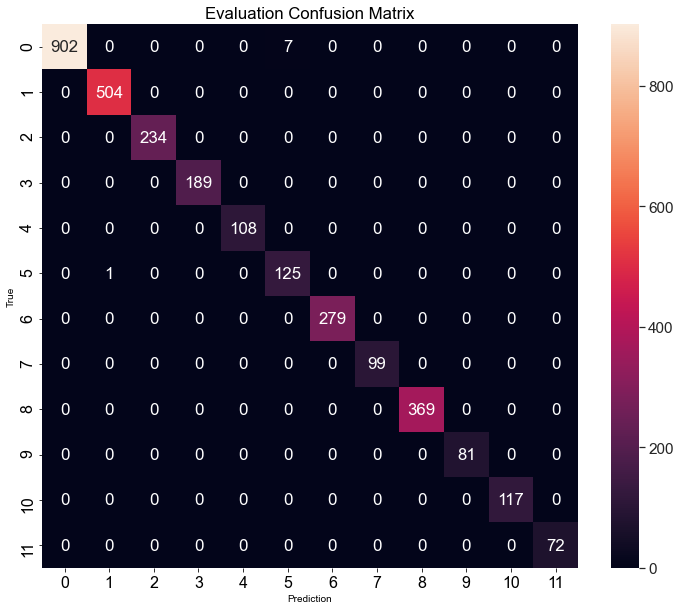

In [9]:
fig, ax = plt.subplots(figsize=[12, 10])
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(arr_truth, arr_pred), annot=True, ax=ax, fmt='.20g')
plt.title("Evaluation Confusion Matrix")
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
plt.xticks(ticks=[k + 0.5 for k in range(12)], fontsize = 16)
plt.yticks(ticks=[k + 0.5 for k in range(12)], fontsize = 16)
plt.savefig("confusion_matrix.svg")

In [10]:
oh_truth = label_binarize(np.asarray(arr_truth), classes=np.arange(16))
print(oh_truth.shape)
oh_truth

(3087, 16)


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
y_score = list(map(lambda x: x.numpy(), logit))
y_score = [item for sublist in y_score for item in sublist]
y_score = np.asarray(y_score)
y_score.shape

(3087, 16)

In [12]:
# Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(oh_truth[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [13]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(oh_truth.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(12)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(12):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 12

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

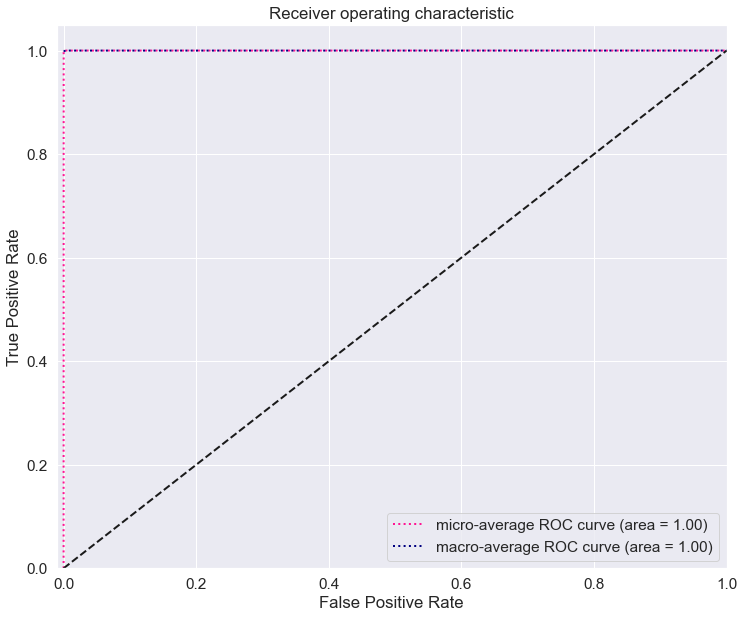

In [14]:
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(12), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [15]:
classes = {
    "Unknown": 0,
    "LookScreen": 1,
    "LookDown": 2,
    "LookSide": 3,
    "LookBack": 4,
    "Leave": 5,
    "Speaking": 6,
    "LookUp": 7,
    "UsePhone": 8,
    "Scratching": 9,
    "Drinking": 10,
    "Typing": 11,
    "Unused-0": 12,
    "Unused-1": 13,
    "Unused-2": 14,
    "Unused-3": 15
}

In [16]:
print(classification_report(np.asarray(arr_truth), np.asarray(arr_pred), target_names=list(classes.keys())[:12]))

              precision    recall  f1-score   support

     Unknown       1.00      0.99      1.00       909
  LookScreen       1.00      1.00      1.00       504
    LookDown       1.00      1.00      1.00       234
    LookSide       1.00      1.00      1.00       189
    LookBack       1.00      1.00      1.00       108
       Leave       0.95      0.99      0.97       126
    Speaking       1.00      1.00      1.00       279
      LookUp       1.00      1.00      1.00        99
    UsePhone       1.00      1.00      1.00       369
  Scratching       1.00      1.00      1.00        81
    Drinking       1.00      1.00      1.00       117
      Typing       1.00      1.00      1.00        72

    accuracy                           1.00      3087
   macro avg       1.00      1.00      1.00      3087
weighted avg       1.00      1.00      1.00      3087

